## Assignment 1 for DS-GA 1011
#### Liangzhi Li


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random
import os, sys

### Read data and split train data into training set and validation set

In [2]:
def readPath(path):
    texts = []
    for file in os.listdir(path):
        filename = path+file
        with open(filename) as f:
            texts.append(f.read())
    return texts

In [3]:
path_pos = '/Users/amberli/Downloads/CDS/fall 2018/nlp/aclImdb/train/pos/'
path_neg = '/Users/amberli/Downloads/CDS/fall 2018/nlp/aclImdb/train/neg/'

In [7]:
from sklearn.model_selection import train_test_split

train_data = []
train_data.extend(readPath(path_pos))
train_data.extend(readPath(path_neg))
train_target = []
train_target.extend([1]*12500)
train_target.extend([0]*12500)

train_data, val_data, train_target, val_target = train_test_split(
    train_data, train_target, test_size=0.2, random_state=2018)

test_data = [] 
test_data.extend(readPath(path_pos))
test_data.extend(readPath(path_neg))
test_target = []
test_target.extend([1]*12500)
test_target.extend([0]*12500)

In [8]:
print ("Train dataset size is {}".format(len(train_data)))
print ("Val dataset size is {}".format(len(val_data)))
print ("Test dataset size is {}".format(len(test_data)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


## Tokenization

In [360]:
import spacy
import string

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')  # 'en_core_web_sm': English Vocabulary, syntax, entities
punctuations = string.punctuation

In [315]:
def tokenize(sent):
    sent = sent.replace('<br />','')
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if (token.text not in punctuations)]  # takenize the sentence and change to lowercase

def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in tqdm_notebook(dataset):
        tokens = tokenize(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

In [405]:
from tqdm import tqdm_notebook
import pickle as pkl

## tokenization scheme 1: lower case + remove punctuation:
def lower_case_remove_punc(parsed):
    return [token.text.lower() for token in parsed if (token.text not in punctuations)]

## scheme 2: lower case + remove punctuation + remove line breakers '\n'
def lower_case_remove_punc_line_break(parsed):
    a = a.text.replace('<br />','')
    a = tokenizer(a)
    return [token.text.lower() for token in parsed if (token.text not in punctuations)]

## scheme 3: without lower case and do not remove anything
def without_tokenization(parsed):
    return [token.text for token in parsed]


def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset
    # in order to create vocabulary later
    all_tokens = []

    for sample in tqdm_notebook(tokenizer.pipe(dataset, disable=['parser', 'tagger', 'ner'], batch_size=512, n_threads=1)):
        tokens = lower_case_remove_punc(sample)
        #tokens = without_tokenization(sample)
        #tokens = lower_case_remove_punc_line_break(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

In [406]:
# val set tokens
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(val_data)
pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))

from tqdm import tqdm
# test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(test_data)
pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset(train_data)
pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))

pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))

Tokenizing val data


A Jupyter Widget

Tokenizing test data


A Jupyter Widget

Tokenizing train data


A Jupyter Widget

### open tokenized files

In [459]:
train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))

In [13]:
# convert word to ngrams
def word2ngram(data,n):
    ngram_list=[]
    for sentence in data:
        ngram = [tuple(sentence[i] for i in range(i,i+n)) for i in range(len(sentence)-n+1)]
        ngram_list.append(ngram)
    return ngram_list

def word2ngram_all_tokens(data,n):
    ngram_list=[]
    for i in range(len(data)-n+1):
        ngram = tuple(data[i] for i in range(i,i+n))
        ngram_list.append(ngram)
    return ngram_list

In [428]:
def word2bigram(data):
    ngram_list=[]
    for sentence in data:
        ngram = [tuple(sentence[i] for i in range(i,i+2)) for i in range(len(sentence)-2+1)]
        for i in range(len(sentence)):
            ngram.append(sentence[i])
        ngram_list.append(ngram)
    return ngram_list

def word2bigram_all_tokens(data):
    ngram_list=[]
    for i in range(len(data)-2+1):
        ngram_list.append(tuple(data[i] for i in range(i,i+2)))
        ngram_list.append(data[i])
    return ngram_list

In [327]:
all_train_tokens = word2ngram_all_tokens(all_train_tokens,2)
train_data_tokens = word2ngram(train_data_tokens,2)
val_data_tokens = word2ngram(val_data_tokens,2)
test_data_tokens = word2ngram(test_data_tokens,2)

In [433]:
all_train_tokens = word2bigram_all_tokens(all_train_tokens)
train_data_tokens = word2bigram(train_data_tokens)
val_data_tokens = word2bigram(val_data_tokens)
test_data_tokens = word2bigram(test_data_tokens)

## Build Vocabulary

In [460]:
# create the vocabulary of most common N tokens in the training set.
from collections import Counter

max_vocab_size = 20000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))    # select most commen 10000 token
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)

In [461]:
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 12037 ; token cooler
Token cooler; token id 12037


In [462]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


## Create pytorch DataLoader

In [463]:
MAX_SENTENCE_LENGTH = 200

import numpy as np
import torch
from torch.utils.data import Dataset

## data loader

class IMDB_Dataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def IMDB_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

In [477]:
BATCH_SIZE = 32
train_dataset = IMDB_Dataset(train_data_indices, train_target)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=True)

val_dataset = IMDB_Dataset(val_data_indices, val_target)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=True)

test_dataset = IMDB_Dataset(test_data_indices, test_target)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=False)

#for i, (data, lengths, labels) in enumerate(train_loader):
#    print (data)
#    print (labels)
#    break

## Define bag-of-ngram model

In [478]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfNgram(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfNgram, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

emb_dim = 100
model = BagOfNgram(len(id2token), emb_dim)

In [479]:
learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
#criterion = torch.nn.NLLLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)


acc = []
Loss = []
for epoch in range(num_epochs):
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    #print('learning rate: {}'.format(learning_rate))
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        #loss_r += loss.item()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            acc.append(val_acc)
            Loss.append(loss)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, loss: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc, loss))
    #learning_rate -= 0.02   # linearly annealing of learning rate
print('max validation accuracy: {}'.format(max(acc)))

Epoch: [1/10], Step: [101/625], Validation Acc: 78.78, loss: 0.5432278513908386
Epoch: [1/10], Step: [201/625], Validation Acc: 84.2, loss: 0.5663700103759766
Epoch: [1/10], Step: [301/625], Validation Acc: 86.08, loss: 0.3199162185192108
Epoch: [1/10], Step: [401/625], Validation Acc: 85.9, loss: 0.2217552810907364
Epoch: [1/10], Step: [501/625], Validation Acc: 87.2, loss: 0.2655215263366699
Epoch: [1/10], Step: [601/625], Validation Acc: 87.9, loss: 0.2848219871520996
Epoch: [2/10], Step: [101/625], Validation Acc: 87.76, loss: 0.20186670124530792
Epoch: [2/10], Step: [201/625], Validation Acc: 87.52, loss: 0.15709614753723145
Epoch: [2/10], Step: [301/625], Validation Acc: 87.66, loss: 0.24893170595169067
Epoch: [2/10], Step: [401/625], Validation Acc: 87.82, loss: 0.29584747552871704
Epoch: [2/10], Step: [501/625], Validation Acc: 87.28, loss: 0.28986629843711853
Epoch: [2/10], Step: [601/625], Validation Acc: 87.16, loss: 0.4625698924064636
Epoch: [3/10], Step: [101/625], Validat

In [380]:
print ("After training for {} epochs".format(num_epochs))
print ("Train Acc {}".format(test_model(train_loader, model)))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 10 epochs
Train Acc 100.0
Val Acc 85.58
Test Acc 97.116


In [ ]:
from torch.optim.lr_scheduler import LambdaLR


learning_rate = 0.1
num_epochs = 3 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
#criterion = torch.nn.NLLLoss()  



#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
#lambda1 = lambda epoch: epoch // 1
#lambda2 = lambda epoch: 0.95 ** epoch
#scheduler = LambdaLR(optimizer, lr_lambda=[lambda1])


# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [473]:
learning_rate = 0.01
num_epochs = 10 # number epoch to train
criterion = torch.nn.CrossEntropyLoss()  
#criterion = torch.nn.NLLLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

ind = []
acc = []

for epoch in range(num_epochs):
    epoch_acc = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        #scheduler.step(loss)
        # loss_r += loss.item()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            epoch_acc.append(val_acc)
            #ind.append(i)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, loss: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc, loss))
    acc.append(epoch_acc)

Epoch: [1/10], Step: [101/625], Validation Acc: 73.48, loss: 0.4332491159439087
Epoch: [1/10], Step: [201/625], Validation Acc: 84.34, loss: 0.4545050859451294
Epoch: [1/10], Step: [301/625], Validation Acc: 84.66, loss: 0.36025264859199524
Epoch: [1/10], Step: [401/625], Validation Acc: 86.78, loss: 0.24696289002895355
Epoch: [1/10], Step: [501/625], Validation Acc: 87.46, loss: 0.3713677227497101
Epoch: [1/10], Step: [601/625], Validation Acc: 86.84, loss: 0.32649579644203186
Epoch: [2/10], Step: [101/625], Validation Acc: 87.86, loss: 0.13408571481704712
Epoch: [2/10], Step: [201/625], Validation Acc: 86.58, loss: 0.21281513571739197
Epoch: [2/10], Step: [301/625], Validation Acc: 87.72, loss: 0.2561343312263489
Epoch: [2/10], Step: [401/625], Validation Acc: 86.86, loss: 0.11022761464118958
Epoch: [2/10], Step: [501/625], Validation Acc: 87.3, loss: 0.20731139183044434
Epoch: [2/10], Step: [601/625], Validation Acc: 87.5, loss: 0.134582981467247
Epoch: [3/10], Step: [101/625], Vali

In [467]:
def test_model_2(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    i=0
    pred = []
    label = []
    DATA = []
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        pred.append(predicted.view_as(labels))
        DATA.append(data)
        label.append(labels)
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return DATA, pred,label

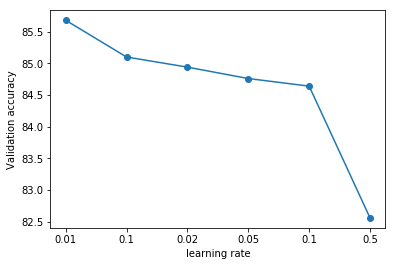

In [458]:
lr = ['0.01','0.1','0.02','0.05','0.1','0.5']
scores = [85.68,85.1,84.94,84.76,84.64,82.56]
plt.plot(scores,'-o')
plt.xticks(range(len(lr)),lr)
plt.xlabel('learning rate')
plt.ylabel('Validation accuracy')
#plt.savefig('learning_rate.png')

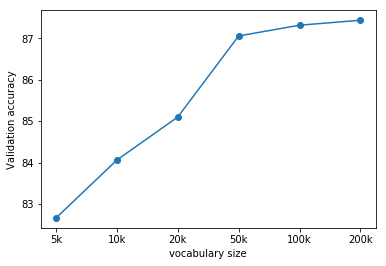

In [482]:
voc_size = ['5k','10k','20k','50k','100k','200k']
scores = [82.66,84.06,85.1,87.06,87.32,87.44]
plt.plot(scores,'-o')
plt.xticks(range(len(scores)),voc_size)
plt.xlabel('vocabulary size')
plt.ylabel('Validation accuracy')
plt.savefig('vocabulary_size.png')

In [ ]:
DATA, pred, label = test_model_2(val_loader,model)